MB_RF_img_plot_t_first_01

Update history:
Feb 16, 2019: creation
    -delta function kernels can be used for both
     spatial and temporal domains for testing
     
    -Lisa's temporal filter is also incoporated
     all responses are computed by convolution
     
    - feedback only turned on after t_on


In [2]:
import numpy as np
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
w, h = 660, 1500 # w - spatial dimension in units of xx mirons, 
                # h - temporal dimension (number of time steps) in units of xx ms

s = np.zeros((h, w))           # a 2D trajectory (stimulation) of a moving bar
response = np.zeros((h,w))     # response of the photo receptors
u = np.zeros((h,w))            # response after feedback
v = np.zeros((h,w))            # low passed of u
gain = np.zeros((h,w))         # gain from g(v)

# set these flags to make the corresponding filter = delta function
s_d_flag = 0 # spatial
t_d_flag = 0 # temporal
v_d_flag = 0 # low pass filter 


flag_lisa = 1

In [60]:
# generate a moving bar
width =133.0
speed = 0.44
contrast = 0.1
for i in range(h): # different time
    for j in range(w): # space
        s[i][j] = contrast*1
        if j > speed*i and j<speed*i + width:
            s[i][j] = 0.0
        

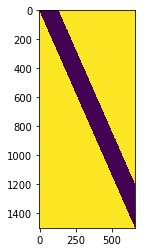

In [61]:
plt.imshow(s)
plt.show()

In [62]:
# spatial filter kernel
# use of two Gussians (one inverted) to approx the receptive field
# or spatial filter
# parameters are chosen to have min at +1 and -1

def k_x(x):
    rc = 0.5
    rs = 0.65
    
    kc = 1.3
    
    ks = 0.9
    
    a = x*x/2/rc/rc
    b = x*x/2/rs/rs
    return kc*np.exp(-a) - ks*np.exp(-b)

In [63]:
# create the spatial filter array
xlen = 101 # filter length
fx = np.zeros(xlen)
for i in range(xlen):
    fx[i] = k_x((i-xlen/2)/20.)
    
if s_d_flag > 0.5 : #delta function here
    npts = int(100)+1
    fx = np.zeros(xlen)
    fx[50]=1.0

In [64]:
#k_t temporal filter
# modeling biphasic response of ganglion cell
# This is an off cell
# with a = 20/16.5 b = 0.3 c = 0.008 and t in msec
# k_t will be zero after 30 msec

def k_t(a,b,c,t):
    if t>0:
        return -a*np.sin(b*t)*np.exp(-c*t*t)
    else:
        return 0.0


In [65]:
# create temporal filter
a = 20/16.5
b = 0.3
c = 0.008
tlen = 61  #temporal filter length
dt = 1.
ft = np.zeros(tlen)
time = np.zeros(tlen)

for i in range(tlen):
    t = i*dt
    time[i] = t-30
    ft[i] = k_t(a,b,c,time[i])
    
if t_d_flag > 0.5: # delta function here
    for i in range(tlen):
        ft[i]=0.0
    ft[30]=1.0

if flag_lisa > 0.5: # Lisa' filter here
    rtc = 40.0**2
    rts = 100.0**2
    ktc = 17
    kts = 6.85
    for i in range(tlen):
        if i < 30:
            ft[i]=0.0
        else:
            t=i-30
            ft[i] = (-ktc*np.exp(-(t*20-70)**2/rtc) + kts*np.exp(-(t*20-150)**2/rts))/12.

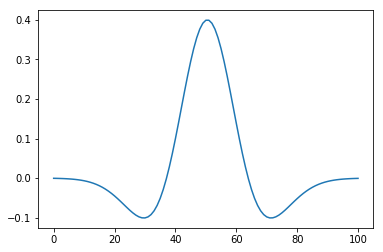

In [66]:
# display spatial filter
plt.plot(fx)
plt.show()

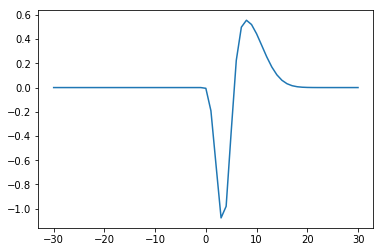

In [67]:
# display temporal filter

plt.plot(time,ft)
plt.show()

In [68]:
# produce response by convultion of input with filters

# temporal first response but we could have performed spatial first

for j in range(w):
    aa = s[:,j]
    response[:,j] = np.convolve(aa,ft,'same')

for i in range(h):
    aa = response[i,:]
    response[i,:] = np.convolve(aa,fx,'same')
    


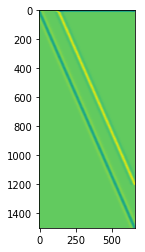

In [69]:
# rescale the respone between 0 to 255

r_response = np.zeros((h, w))

max_val = np.max(response)
min_val = np.min(response)

factor = 255.0/(max_val-min_val)

for i in range(h):
    for j in range(w):
        r_response[i,j]= (response[i,j] - min_val)*factor
#plt.imshow(r_response,cmap='gray')
plt.imshow(r_response)
plt.show()

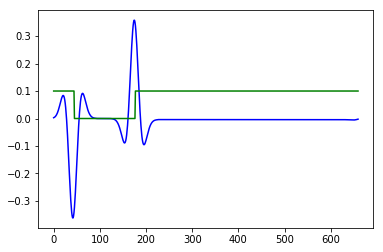

In [70]:
# plot spatial response
plt.plot(response[100,:],'b')
plt.plot(s[100,:],'g')
plt.show()

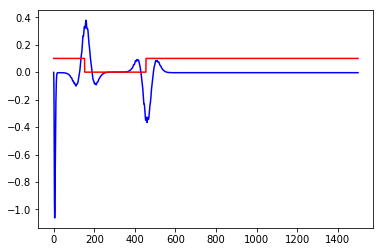

In [71]:
# plot temporal response
plt.plot(response[:,200],'b')
plt.plot(s[:,200],'r')
plt.show()

In [72]:
# feedback of gain on low passed firing rate v (of u)
def g(v):
    if v < 0:
        return 1
    else:
        return 1/(1 + v**4)


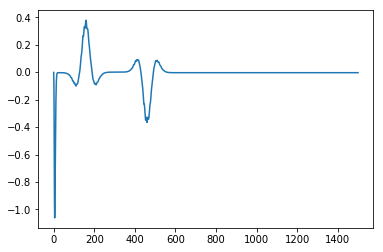

In [73]:
#test here
t_response = response[:,200]
plt.plot(t_response)

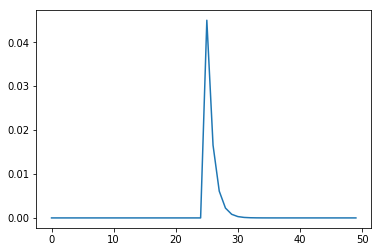

In [75]:
# low pass convolution filter
npts = 50 #length of filter
B = 0.045
tau = 1
l_t = np.zeros(npts)

for i in range(npts):
    l_t[i] = 0
    if i>= int(npts/2):
        l_t[i]=B*np.exp(-(i-int(npts/2))/tau)
if v_d_flag > 0.5:
    for i in range(npts):
        l_t[i] = 0.0
    l_t[int(npts/2)] = 1.0
plt.plot(l_t)

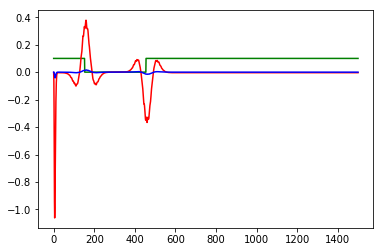

In [76]:
aa = np.convolve(t_response,l_t,'same')
plt.plot(s[:,200],'g')
plt.plot(response[:,200],'r')
plt.plot(aa*.6,'b')

In [77]:
# test of convolution of a delta function with l_t
#test = np.zeros(1001)
#test[501] = 1
#plt.plot(test)
#plt.plot(np.convolve(test,l_t*10,'same'))

In [78]:
# computation of u from response and feedback

len = 100           # length for computation of v from u
u_t = np.zeros(len) # temp storage for the previous values of u of length (len)
i_on = 150          # turn on feedback on i > i_on

for i in range(h): #march in time step
    print(i)
 
    for j in range(w):
        
       # determine the gain factor used for each spatial point    
        if i == 0:
            factor_j = 1. # assume gain =1 for the fist step for all j
        else:
            factor_j = gain[i-1,j] # use the gain computed from previous time step
            
        u[i,j] = factor_j*response[i,j]
        
        if i<i_on:      # before i_on, no feedback --> gain = 1
            v[i,j] = u[i,j]
            gain[i,j] = 1.0
            
        else:                                   # after i_on, compute gain for diffrent location
            for ii in range(len):               # construction of u_t
                index = i-len+ii                #  - the last len values of u
                u_t[ii]= u[index,j]
            aa = np.convolve(u_t,l_t,'same')    # compute lower passed u_t by using l_t
            v[i,j] = aa[-1]                     # use the last element for the value of v
            gain[i,j] = g(v[i,j])               # obtain gain for the present time step

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

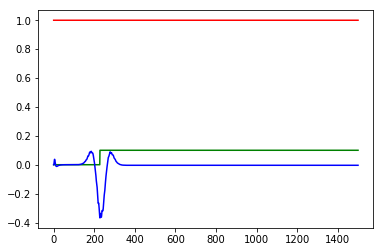

In [79]:
#response before feedback
plt.plot(s[:,100],'g')
plt.plot(u[:,100],'b')
plt.plot(gain[:,150],'r')

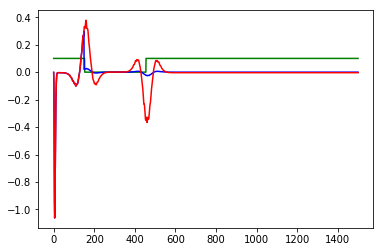

In [80]:
# response after feedback
plt.plot(s[:,200],'g')
plt.plot(v[:,200],'b')
plt.plot(u[:,200],'r')

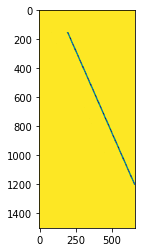

In [81]:
plt.imshow(gain)